## DMW1 Lab 1: Customer Personality Analysis Dataset

## Import Libraries

In [2]:
import pandas as pd
# import matplotlib as plt
import seaborn as sns
import numpy as np
import sqlite3
from matplotlib.colors import ListedColormap
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Create Database

In [3]:
# data = pd.read_csv('/mnt/data/public/customer-personality-analysis/marketing_campaign.csv', sep='\t')
# print(data.info())
# print(f"DataFrame Shape: {data.shape}")
# data

In [4]:
# conn = sqlite3.connect('Lab1.db')
# data.to_sql('Customer_Personality_Analysis', conn, if_exists='replace', index=False)
# conn.commit()
# conn.close()

In [5]:
conn = sqlite3.connect('Lab1.db')
table = pd.read_sql('SELECT * FROM Customer_Personality_Analysis', conn) # Test to see if the table is in the database
table

ID  Year_Birth   Education Marital_Status   Income  Kidhome  \
0      5524        1957  Graduation         Single  58138.0        0   
1      2174        1954  Graduation         Single  46344.0        1   
2      4141        1965  Graduation       Together  71613.0        0   
3      6182        1984  Graduation       Together  26646.0        1   
4      5324        1981         PhD        Married  58293.0        1   
...     ...         ...         ...            ...      ...      ...   
2235  10870        1967  Graduation        Married  61223.0        0   
2236   4001        1946         PhD       Together  64014.0        2   
2237   7270        1981  Graduation       Divorced  56981.0        0   
2238   8235        1956      Master       Together  69245.0        0   
2239   9405        1954         PhD        Married  52869.0        1   

      Teenhome Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  \
0            0  04-09-2012       58       635  ...                  7   
1            1  08-03-2014       38        11  ...                  5   
2            0  21-08-2013       26       426  ...                  4   
3            0  10-02-2014       26        11  ...                  6   
4            0  19-01-2014       94       173  ...                  5   
...        ...         ...      ...       ...  ...                ...   
2235         1  13-06-2013       46       709  ...                  5   
2236         1  10-06-2014       56       406  ...                  7   
2237         0  25-01-2014       91       908  ...                  6   
2238         1  24-01-2014        8       428  ...                  3   
2239         1  15-10-2012       40        84  ...                  7   

      AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  \
0                0             0             0             0             0   
1                0             0             0             0             0   
2                0             0             0             0             0   
3                0             0             0             0             0   
4                0             0             0             0             0   
...            ...           ...           ...           ...           ...   
2235             0             0             0             0             0   
2236             0             0             0             1             0   
2237             0             1             0             0             0   
2238             0             0             0             0             0   
2239             0             0             0             0             0   

      Complain  Z_CostContact  Z_Revenue  Response  
0            0              3         11         1  
1            0              3         11         0  
2            0              3         11         0  
3            0              3         11         0  
4            0              3         11         0  
...        ...            ...        ...       ...  
2235         0              3         11         0  
2236         0              3         11         0  
2237         0              3         11         0  
2238         0              3         11         0  
2239         0              3         11         1  

[2240 rows x 29 columns]

In [6]:
conn.close()

## Exploratory Data Analysis

### Data Cleaning

In [7]:
df_main = table.dropna().copy()
print("Original Data Size:", len(table))
print("Missing Data points dropped:", len(df_main))

Original Data Size: 2240
Missing Data points dropped: 2216


Converting Customer Date into Number of days as a customer with reference to the oldest and the newest recorded customer

In [8]:
df_main["Dt_Customer"] = pd.to_datetime(df_main["Dt_Customer"], dayfirst=True)
dates = []
for i in df_main["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))
df_main["Dt_Customer"].head()

The newest customer's enrolment date in therecords: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


0   2012-09-04
1   2014-03-08
2   2013-08-21
3   2014-02-10
4   2014-01-19
Name: Dt_Customer, dtype: datetime64[ns]

In [9]:
newest = df_main["Dt_Customer"].max()
# number of days each customer has been active, measured relative to the newest record
df_main["Dt_Customer"] = (newest - df_main["Dt_Customer"]).dt.days
df_main.rename(columns={"Dt_Customer": "Days as Customer"}, inplace=True)
df_main["Days as Customer"].head()

0    663
1    113
2    312
3    139
4    161
Name: Days as Customer, dtype: int64

Other Changes to simplify dataset

In [10]:
# Converting Year of Birth to an Age Value
df_main["Year_Birth"] = (newest.year - table["Year_Birth"])
df_main.rename(columns={"Year_Birth": "Age"}, inplace=True)
# print(df_main["Age"].head())

# Combining Total Purchases
df_main["Spent"] = df_main["MntWines"]+ df_main["MntFruits"]+ df_main["MntMeatProducts"]+ df_main["MntFishProducts"]+ df_main["MntSweetProducts"]+ df_main["MntGoldProds"]
# print(df_main["Spent"].head())

# Combining Total Purchases with Weight on each product
df_main["Spent_Weighted"] = (df_main["MntWines"]*3+ 
                             df_main["MntFruits"]*1+ 
                             df_main["MntMeatProducts"]*5+ 
                             df_main["MntFishProducts"]*4+ 
                             df_main["MntSweetProducts"]*2+ 
                             df_main["MntGoldProds"]*6)
# print(df_main["Spent_Weighted"].head())

# Simplifying Marital Status Column
df_main["Marital_Status"]=table["Marital_Status"].replace({"Married":"Not Alone", "Together":"Not Alone", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Not Alone", "Divorced":"Alone", "Single":"Alone",})
df_main.rename(columns={"Marital_Status": "Relationship Status"}, inplace=True)

#
#Feature indicating total children living in the household
df_main["Children"]=table["Kidhome"]+table["Teenhome"]
df_main = df_main.drop(columns = ["Kidhome","Teenhome"])

#Feature for total members in the householde
status_weight = {"Alone": 1, "Not Alone": 2}
df_main["Family_Size"] = (
    df_main["Relationship Status"].map(status_weight).astype("Int64")
    + df_main["Children"]
)

#Dropping some of the redundant features
to_drop = ["Z_CostContact", "Z_Revenue","Complain","Response"]
df_main = df_main.drop(to_drop, axis=1)

#Feature pertaining parenthood
df_main["Is_Parent"] = np.where(df_main.Children> 0, 1, 0)

In [11]:
# df_main["Education"]=table["Education"].replace({"Basic":1,"2n Cycle":3, "Graduation":2, "Master":4, "PhD":5})
df_main.head()

ID  Age   Education Relationship Status   Income  Days as Customer  \
0  5524   57  Graduation               Alone  58138.0               663   
1  2174   60  Graduation               Alone  46344.0               113   
2  4141   49  Graduation           Not Alone  71613.0               312   
3  6182   30  Graduation           Not Alone  26646.0               139   
4  5324   33         PhD           Not Alone  58293.0               161   

   Recency  MntWines  MntFruits  MntMeatProducts  ...  AcceptedCmp3  \
0       58       635         88              546  ...             0   
1       38        11          1                6  ...             0   
2       26       426         49              127  ...             0   
3       26        11          4               20  ...             0   
4       94       173         43              118  ...             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Spent  \
0             0             0             0             0   1617   
1             0             0             0             0     27   
2             0             0             0             0    776   
3             0             0             0             0     53   
4             0             0             0             0    422   

   Spent_Weighted  Children  Family_Size  Is_Parent  
0            6115         0            1          0  
1             110         2            3          1  
2            2700         0            2          0  
3             213         1            3          1  
4            1480         1            3          1  

[5 rows x 28 columns]

Removing Outliers

In [12]:
import pandas as pd

def remove_outliers_iqr(df, columns=None, multiplier=1.5):
    df_clean = df.copy()
    
    # If no columns specified, use all numeric columns
    if columns is None:
        columns = df_clean.select_dtypes(include=['float64', 'int64']).columns
    
    print(f"Applying outlier removal to: {list(columns)}")

    for col in columns:
        Q1 = df_clean[col].quantile(0.1)
        Q3 = df_clean[col].quantile(0.9)
        IQR = Q3 - Q1
        lower = Q1 - multiplier * IQR
        upper = Q3 + multiplier * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

    return df_clean

# Choose columns to clean (you can edit this list)
cols_to_clean = ["Income", "Spent", "MntWines","Age"]
df_cleaned = remove_outliers_iqr(df_main, columns=cols_to_clean)
print(f"Before: {df_main.shape}, After: {df_cleaned.shape}")
df_main = df_cleaned.copy()


Applying outlier removal to: ['Income', 'Spent', 'MntWines', 'Age']
Before: (2216, 28), After: (2212, 28)


Initial Data Describe

In [13]:
df_main.describe()

ID          Age         Income  Days as Customer  \
count   2212.000000  2212.000000    2212.000000       2212.000000   
mean    5585.160940    45.086347   51958.810579        353.714286   
std     3247.523735    11.701599   21527.278844        202.494886   
min        0.000000    18.000000    1730.000000          0.000000   
25%     2814.750000    37.000000   35233.500000        180.000000   
50%     5454.500000    44.000000   51371.000000        356.000000   
75%     8418.500000    55.000000   68487.000000        529.000000   
max    11191.000000    74.000000  162397.000000        699.000000   

           Recency     MntWines    MntFruits  MntMeatProducts  \
count  2212.000000  2212.000000  2212.000000      2212.000000   
mean     49.019439   305.287523    26.329566       167.029837   
std      28.943121   337.322940    39.744052       224.254493   
min       0.000000     0.000000     0.000000         0.000000   
25%      24.000000    24.000000     2.000000        16.000000   
50%      49.000000   175.500000     8.000000        68.000000   
75%      74.000000   505.000000    33.000000       232.250000   
max      99.000000  1493.000000   199.000000      1725.000000   

       MntFishProducts  MntSweetProducts  ...  AcceptedCmp3  AcceptedCmp4  \
count      2212.000000       2212.000000  ...   2212.000000   2212.000000   
mean         37.648734         27.046564  ...      0.073689      0.074141   
std          54.772033         41.090991  ...      0.261323      0.262060   
min           0.000000          0.000000  ...      0.000000      0.000000   
25%           3.000000          1.000000  ...      0.000000      0.000000   
50%          12.000000          8.000000  ...      0.000000      0.000000   
75%          50.000000         33.000000  ...      0.000000      0.000000   
max         259.000000        262.000000  ...      1.000000      1.000000   

       AcceptedCmp5  AcceptedCmp1  AcceptedCmp2        Spent  Spent_Weighted  \
count   2212.000000   2212.000000   2212.000000  2212.000000     2212.000000   
mean       0.072785      0.064195      0.013562   607.268083     2245.584539   
std        0.259842      0.245156      0.115691   602.513364     2244.817779   
min        0.000000      0.000000      0.000000     5.000000       18.000000   
25%        0.000000      0.000000      0.000000    69.000000      273.000000   
50%        0.000000      0.000000      0.000000   397.000000     1438.500000   
75%        0.000000      0.000000      0.000000  1048.000000     3793.750000   
max        1.000000      1.000000      1.000000  2525.000000     9515.000000   

          Children  Family_Size    Is_Parent  
count  2212.000000       2212.0  2212.000000  
mean      0.947559     2.594033     0.714286  
std       0.749466     0.906143     0.451856  
min       0.000000          1.0     0.000000  
25%       0.000000          2.0     0.000000  
50%       1.000000          3.0     1.000000  
75%       1.000000          3.0     1.000000  
max       3.000000          5.0     1.000000  

[8 rows x 26 columns]

### Statistical Analysis
- pvalue comparisons
- what groups are significantly different

Confusion Heatmap Analysis
- Strong Positive Correlation on Amount Spent(Both Amount and Weighted) to Income
- Strong Positive Correlation of Income to No. Store Visits
- Strong Negative Correlation of Income to No. of Web Purchases
- Strong Positive Correlation of Wine to 

<Axes: >

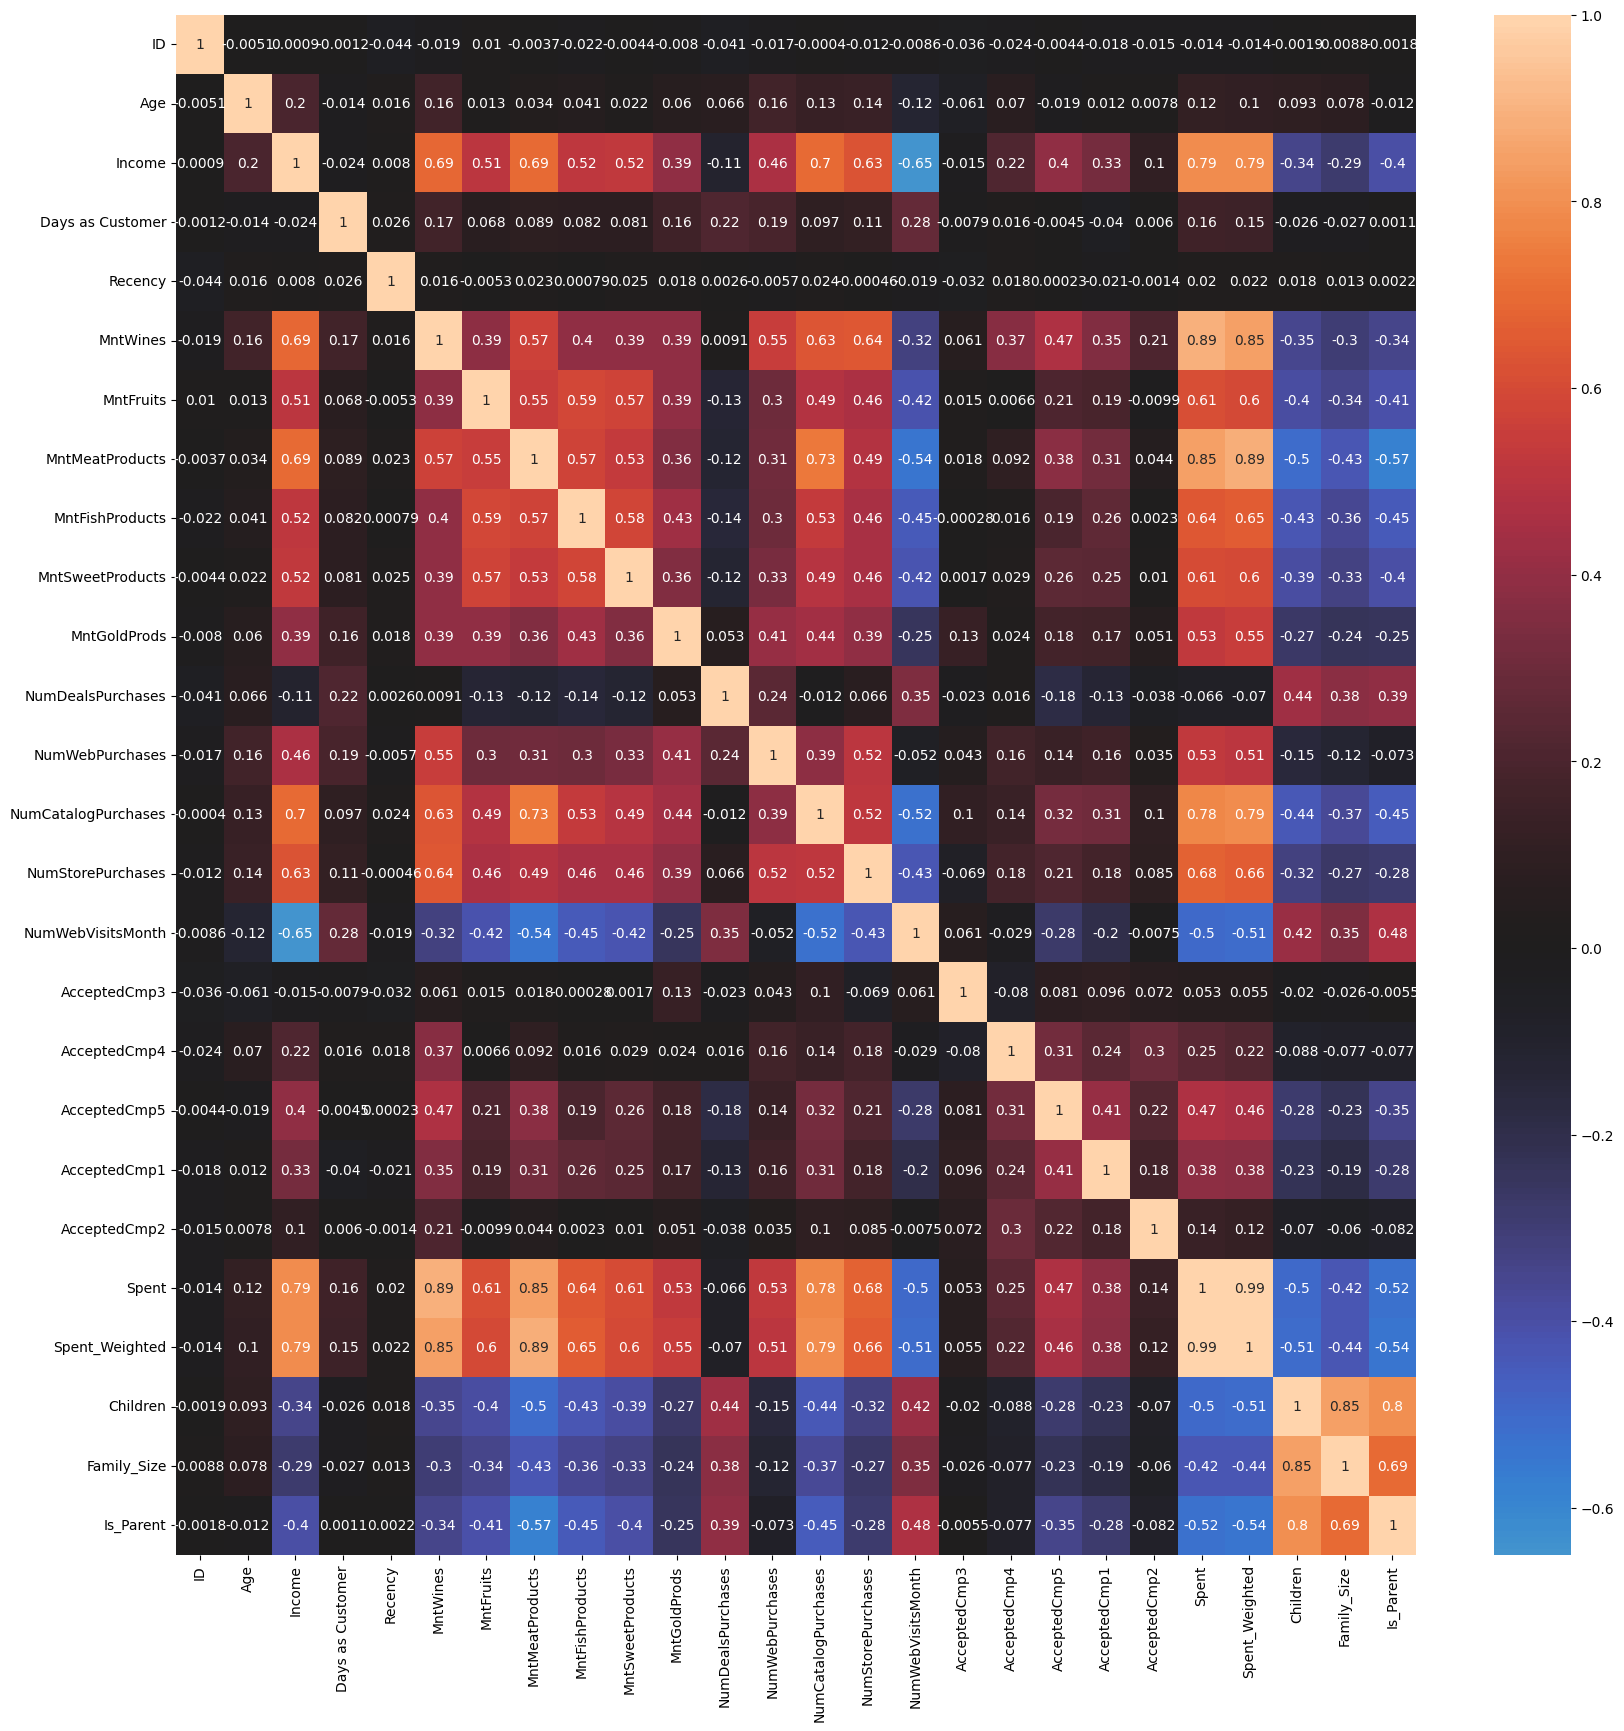

In [14]:
# Color  Setup
# cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#correlation matrix
corrmat= df_main.corr(numeric_only=True)
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, center=0)

Correlation Table
Correlation Observation
- slight positive correlation of number of kids to income
- Strong Positive Correlation for amount of Wine Purchased with Amount Spent
- Strong Negative Correlation with Number of Website Visits with Individuals Income
- positive correlation observed in the number of store purchases with income
- negative correlation observed in the number of website visits with income



In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
# import numpy as np
# import pandas as pd

# Standardized data for r2 and slope
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_main.select_dtypes(include=["float64", "int64"])),
    columns=df_main.select_dtypes(include=["float64", "int64"]).columns
)

# Absolute data for correlation data
corr_pairs = (
    corrmat.unstack()
    .reset_index()
    .rename(columns={'level_0': 'Variable 1', 'level_1': 'Variable 2', 0: 'Correlation'})
)

# Remove self-correlations
corr_pairs = corr_pairs[corr_pairs["Variable 1"] != corr_pairs["Variable 2"]]

# Remove duplicate pairs
corr_pairs["pair"] = corr_pairs.apply(lambda x: "-".join(sorted([x["Variable 1"], x["Variable 2"]])), axis=1)
corr_pairs = corr_pairs.drop_duplicates(subset="pair").drop(columns="pair")

# Filter by minimum correlation if needed
corr_pairs = corr_pairs[abs(corr_pairs["Correlation"]) > 0.0].copy()

# --- Add slope and R² for each pair ---
slopes = []
r2_scores = []

for _, row in corr_pairs.iterrows():
    x = df_main[[row["Variable 1"]]].values
    y = df_main[row["Variable 2"]].values
    
    # Drop NaNs to avoid regression errors
    mask = ~np.isnan(x.flatten()) & ~np.isnan(y)
    x_clean = x[mask].reshape(-1, 1)
    y_clean = y[mask]
    
    if len(x_clean) > 1:
        model = LinearRegression()
        model.fit(x_clean, y_clean)
        slope = model.coef_[0]
        r2 = model.score(x_clean, y_clean)
    else:
        slope, r2 = np.nan, np.nan  # handle edge cases with few valid points
    
    slopes.append(slope)
    r2_scores.append(r2)

corr_pairs["Slope"] = slopes
corr_pairs["R²"] = r2_scores

# Sort for convenience
corr_pairs = corr_pairs.sort_values(by="Correlation", ascending=False).reset_index(drop=True)

corr_pairs.head(10)


Variable 1      Variable 2  Correlation       Slope        R²
0                Spent  Spent_Weighted     0.993448    3.701346  0.986940
1             MntWines           Spent     0.892996    1.595036  0.797442
2      MntMeatProducts  Spent_Weighted     0.890176    8.910777  0.792412
3             Children     Family_Size     0.849732    1.027370  0.722044
4             MntWines  Spent_Weighted     0.848488    5.646520  0.719932
5      MntMeatProducts           Spent     0.845543    2.271753  0.714943
6             Children       Is_Parent     0.799802    0.482204  0.639683
7               Income           Spent     0.792740    0.022187  0.628436
8  NumCatalogPurchases  Spent_Weighted     0.792127  607.397203  0.627465
9               Income  Spent_Weighted     0.788605    0.082234  0.621898

In [16]:
df_main.columns

Index(['ID', 'Age', 'Education', 'Relationship Status', 'Income',
       'Days as Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Spent', 'Spent_Weighted', 'Children', 'Family_Size',
       'Is_Parent'],
      dtype='object')

Pairplot Analysis. Customer Demographic
Cluster/Histogram Observation
- Parents have a higher chance to have more Website Visits than Non Parents
- Parents have a higher chance to have less income than Non Parents
- Parents generally spend less than Non parents
- suggests parents may spend less than people who arent parents
- suggests more people who are not parents have higher income
- suggests parents spend more on wine and less on meat than people who arent parents

Relative Plot Of Some Selected Features: A Data Subset


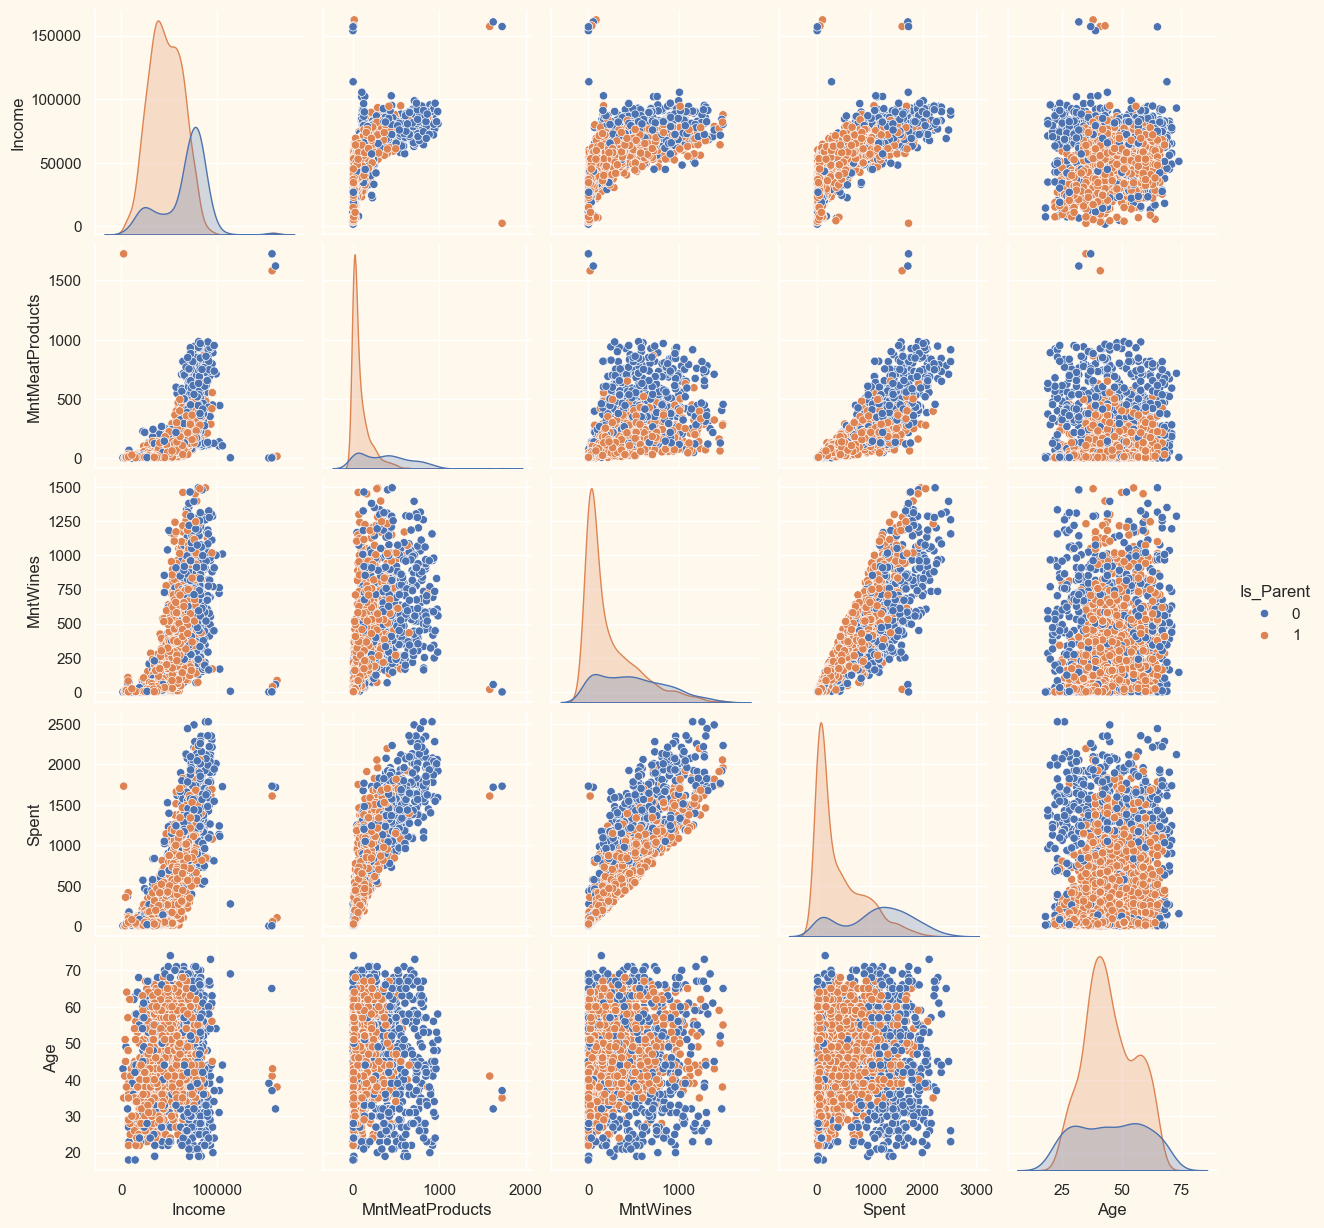

In [17]:

# Set custom background
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})

# Define palette and colormap
# palette = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
# cmap = colors.ListedColormap(palette)

# Features to plot
To_Plot = ["Income", "MntMeatProducts","MntWines", "Spent", "Age"]
To_Plot = ["Income", "MntMeatProducts","MntWines", "Spent", "Age" ]

print("Relative Plot Of Some Selected Features: A Data Subset")

# Plot
sns.pairplot(
    data=df_main,
    vars=To_Plot,
    # hue="Education",
    # hue="Relationship Status"
    hue="Is_Parent"
    # diag_kind="kde"   # optional: smooth density on diagonals
)

plt.show()


Pairplot Analysis. Purchase Behavior
- Parents seem to have more interest in Purchase Deals than Non Parents
- Parents have higher Website Visits than non parents


Relative Plot Of Some Selected Features: A Data Subset


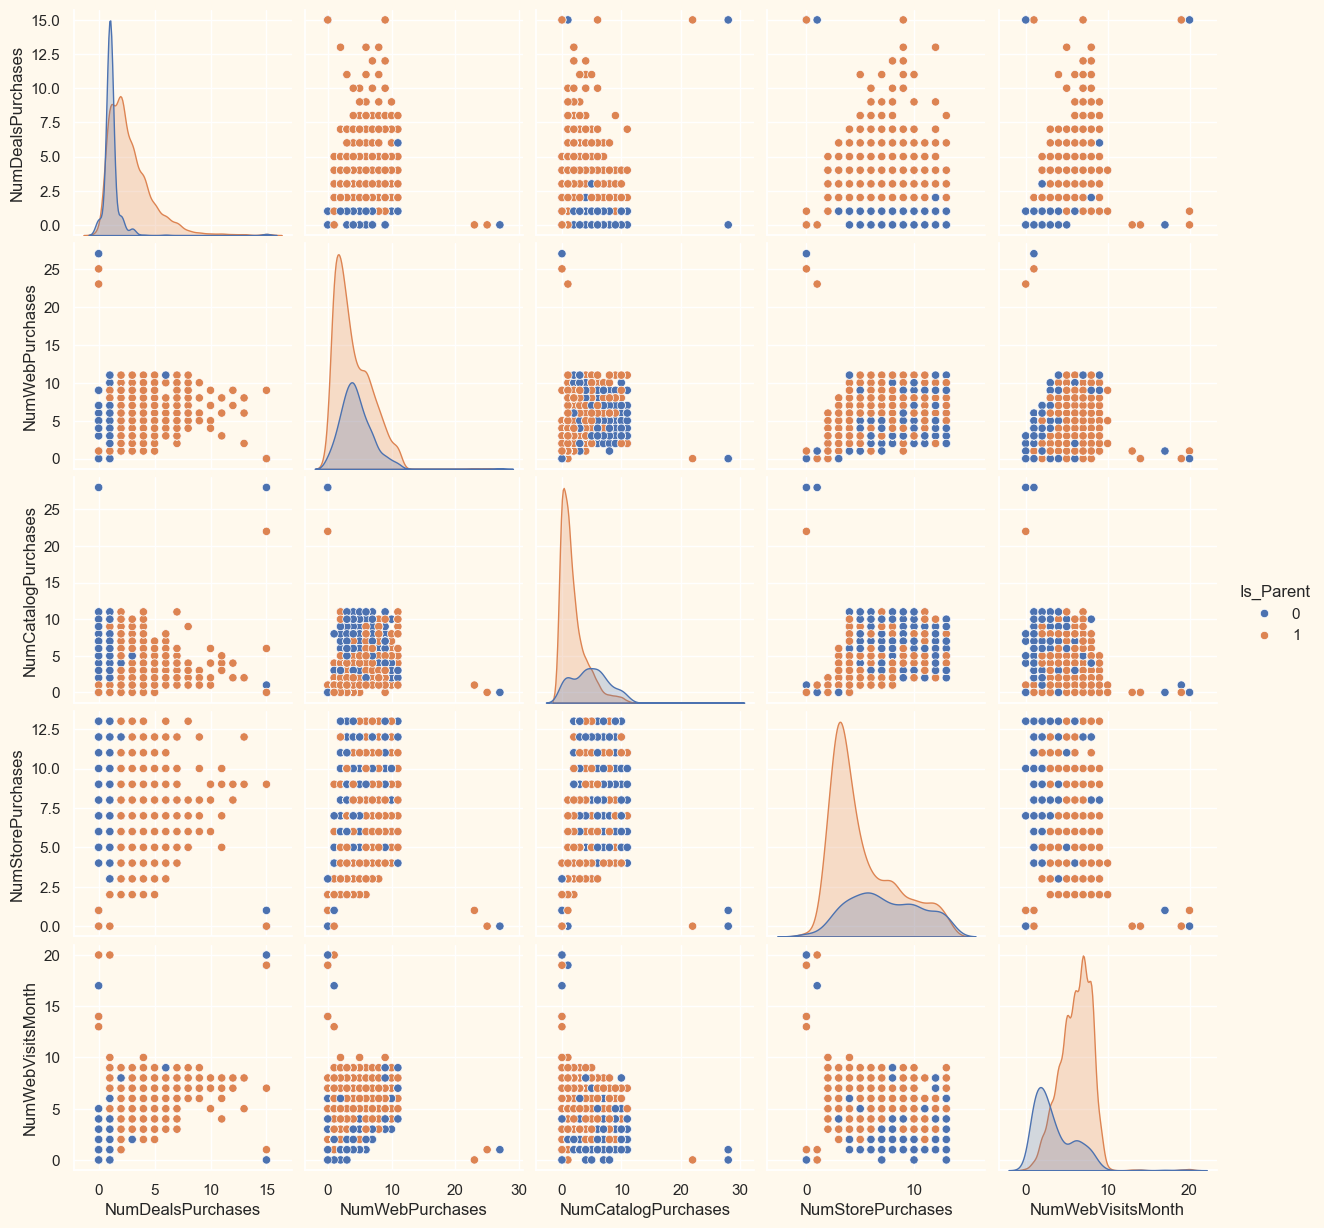

In [18]:

# Set custom background
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})

# Define palette and colormap
# palette = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
# cmap = colors.ListedColormap(palette)

# Features to plot
To_Plot = ['NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', ]

print("Relative Plot Of Some Selected Features: A Data Subset")

# Plot
sns.pairplot(
    data=df_main,
    vars=To_Plot,
    # hue="Education",
    # hue="Relationship Status"
    hue="Is_Parent"
    # diag_kind="kde"   # optional: smooth density on diagonals
)

plt.show()


Histogram Analysis
- Outliers removed for age and income based on observation from histogram data

In [19]:
df_main.columns

Index(['ID', 'Age', 'Education', 'Relationship Status', 'Income',
       'Days as Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Spent', 'Spent_Weighted', 'Children', 'Family_Size',
       'Is_Parent'],
      dtype='object')

In [20]:
def plot_hist_subplots(df, columns=None, n_cols=3, nbins=30,v_space=0.05, color="#9E726F"):
    """
    Create Plotly histogram subplots for selected columns.

    Parameters:
        df (pd.DataFrame): Data source
        columns (list): Columns to plot. If None, all numeric columns are used.
        n_cols (int): Number of subplots per row
        nbins (int): Number of bins for each histogram
        color (str): Histogram color (hex)
    """
    # Auto-select numeric columns if none are specified
    if columns is None:
        columns = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

    # Handle case where list is empty
    if len(columns) == 0:
        raise ValueError("No numeric columns to plot.")

    # Grid layout
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig = make_subplots(
        rows=n_rows, cols=n_cols,
        subplot_titles=columns,
        horizontal_spacing=0.08,
        vertical_spacing=v_space,
    )

    # Add histograms
    for i, col in enumerate(columns):
        row = i // n_cols + 1
        col_pos = i % n_cols + 1
        fig.add_trace(
            go.Histogram(
                x=df[col],
                nbinsx=nbins,
                marker_color=color,
                opacity=0.8,
                name=col
            ),
            row=row, col=col_pos
        )

    # Layout
    fig.update_layout(
        height=n_rows * 200,
        # width=1000,
        showlegend=False,
        title_text="Distribution of Selected Features",
        template="plotly_white"
    )

    fig.show()

# Select specific columns to visualize
plot_hist_subplots(df_main, columns=['ID', 'Age', 'Education', 
        'Relationship Status', 'Income',
        'Days as Customer', 'Recency', 'MntWines', 'MntFruits',
        'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
        'MntGoldProds', 'Spent', 'Spent_Weighted',
        ], n_cols=2, nbins=9,color="#F3AB60")


In [21]:


plot_hist_subplots(df_main, columns=[
        'NumDealsPurchases', 'NumWebPurchases',
        'NumCatalogPurchases','NumWebVisitsMonth',
        ], n_cols=2, nbins=15,v_space=0.2,color="#F3AB60")

In [22]:
plot_hist_subplots(df_main, columns=[
        'Children', 'Family_Size', 'Is_Parent','NumStorePurchases',
        ], n_cols=2, nbins=5,v_space=0.2,color="#F3AB60")

Recency. Frequency. Monetary Analysis

### Statistical Analysis: Customer Behavior Data

Boxplot Analysis
- Education Background
    - Basic has just graduated highschool. No Degree
    - Graduation. Has at least a Bachelor's Degree
    - 2n Cycle. In the process of Studying to get a Masters
- Observations
    - PhD Highest median income. Graduation people at 2nd. Basic education a the lowest income distribution

In [23]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

df_sub = df_main.copy()

# Optional: define default order for consistency
edu_order = ["Basic", "Graduation", "Master", "2n Cycle", "PhD"]
df_sub["Education"] = pd.Categorical(df_sub["Education"], categories=edu_order, ordered=True)

# ---- 1. Compute median order based on Income ----
median_income = df_sub.groupby("Education")["Income"].median().sort_values()
sorted_edu_order = median_income.index.tolist()
print("Education sorted by increasing median income:", sorted_edu_order)

# ---- 2. Create subplot figure ----
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.07,
    subplot_titles=("Age distribution by education level", "Income distribution by education level")
)

# ---- 3. AGE boxplot ----
fig_age = px.box(
    df_sub,
    x="Education",
    y="Age",
    category_orders={"Education": sorted_edu_order}
)

# ---- 4. INCOME boxplot ----
fig_income = px.box(
    df_sub,
    x="Education",
    y="Income",
    category_orders={"Education": sorted_edu_order}
)

# ---- 5. Add both traces to subplot ----
for trace in fig_age.data:
    fig.add_trace(trace, row=1, col=1)

for trace in fig_income.data:
    fig.add_trace(trace, row=2, col=1)

# ---- 6. Update layout ----
fig.update_layout(
    height=800,
    showlegend=False,
    title_text="Age and Income Distribution by Education Level (Sorted by Median Income)",
)

# ---- 7. Set axis titles and ranges ----
fig.update_yaxes(title_text="Age", row=1, col=1, range=[10, 80])
fig.update_yaxes(title_text="Income", row=2, col=1, range=[0, 120000])
fig.update_xaxes(title_text="Education level", row=2, col=1)

# ---- 8. Enforce sorted education order ----
fig.update_xaxes(categoryorder="array", categoryarray=sorted_edu_order)

fig.show()


Education sorted by increasing median income: ['Basic', '2n Cycle', 'Master', 'Graduation', 'PhD']


C:\Users\Enzo\AppData\Local\Temp\ipykernel_33188\3261920106.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [24]:
import pandas as pd
import plotly.express as px

# # Copy original dataframe
# df_sub = df_main.copy()

# Define 5-year bins (adjust max age to fit your dataset)
bins = range(0, df_sub["Age"].max() + 5, 5)
labels = [f"{i}-{i+4}" for i in bins[:-1]]

# Create a new column for age group
df_sub["AgeGroup"] = pd.cut(df_sub["Age"], bins=bins, labels=labels, right=False)

# Ensure correct categorical order (ascending age)
df_sub["AgeGroup"] = pd.Categorical(df_sub["AgeGroup"], categories=labels, ordered=True)

# Calculate frequency per age group
age_counts = df_sub["AgeGroup"].value_counts().sort_index()



# Update labels to include frequency (e.g. '20–24 (n=42)')
age_labels = [f"{grp} (n={age_counts.get(grp, 0)})" for grp in labels]

# Create mapping from original label to label-with-count
label_map = dict(zip(labels, age_labels))
df_sub["AgeGroupLabel"] = df_sub["AgeGroup"].map(label_map)

# Create boxplot
fig = px.box(
    df_sub,
    x="AgeGroupLabel",
    y="Income",
    labels={"AgeGroupLabel": "Age group (5-year bins)", "Income": "Income"},
    title="Income distribution by 5-year age group",
)

# Force correct order on x-axis
fig.update_xaxes(categoryorder="array", categoryarray=age_labels)
fig.update_layout(yaxis_range=[0, 120000])  # show bins 3rd to 9th initially
fig.update_xaxes(range=[2, 15])
fig.show()



# Optionally show frequencies
print("Frequency per age group:")
print(age_counts)

Frequency per age group:
AgeGroup
0-4        0
5-9        0
10-14      0
15-19      7
20-24     54
25-29    158
30-34    200
35-39    352
40-44    380
45-49    289
50-54    213
55-59    246
60-64    207
65-69     91
70-74     15
Name: count, dtype: int64


### Statistical Analysis: Grocery Item Data

Observations
- Wines are the most sold item next to meat

In [25]:
df_campaign = df_main.loc[:,['MntWines', 'MntFruits', 'MntMeatProducts', 
                             'MntFishProducts','MntSweetProducts','MntGoldProds']]
df_campaign.sum().sort_values(ascending=False)

MntWines            675296
MntMeatProducts     369470
MntGoldProds         97164
MntFishProducts      83279
MntSweetProducts     59827
MntFruits            58241
dtype: int64

### Statistical Analysis: Campaign Data
Observations
- Based on Frequency Count Campaign 4,3 and 5 attracted a lot of people. Campaign 2 attracted significantly less people

In [26]:
df_main.columns

Index(['ID', 'Age', 'Education', 'Relationship Status', 'Income',
       'Days as Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Spent', 'Spent_Weighted', 'Children', 'Family_Size',
       'Is_Parent'],
      dtype='object')

In [27]:
# Create labeled subsets for each campaign
df_campaign0 = df_main[df_main['AcceptedCmp1'] == 0].copy()
df_campaign0["Campaign"] = "No Campaign"

df_campaign1 = df_main[df_main['AcceptedCmp1'] == 1].copy()
df_campaign1["Campaign"] = "Campaign 1"

df_campaign2 = df_main[df_main['AcceptedCmp2'] == 1].copy()
df_campaign2["Campaign"] = "Campaign 2"

df_campaign3 = df_main[df_main['AcceptedCmp3'] == 1].copy()
df_campaign3["Campaign"] = "Campaign 3"

df_campaign4 = df_main[df_main['AcceptedCmp4'] == 1].copy()
df_campaign4["Campaign"] = "Campaign 4"

df_campaign5 = df_main[df_main['AcceptedCmp5'] == 1].copy()
df_campaign5["Campaign"] = "Campaign 5"

# Combine them into one DataFrame
df_campaign_all = pd.concat([
    # df_campaign0,
    df_campaign1,
    df_campaign2,
    df_campaign3,
    df_campaign4,
    df_campaign5
], ignore_index=True)

# Check shape and distribution
print('No. of IDs purchased under each Campaign \n', df_campaign_all["Campaign"].value_counts())
print(df_campaign_all.shape)


No. of IDs purchased under each Campaign 
 Campaign
Campaign 4    164
Campaign 3    163
Campaign 5    161
Campaign 1    142
Campaign 2     30
Name: count, dtype: int64
(660, 29)


Boxplot Analysis
- Based on Income Boxplot, Campaign 5 and Campaign 1 targeted a lot of High Income Earners. Campaign 3 Targets a lot of lower income earners.
- Based on the MntMeatProd Boxplot, Campaign 5 and Campaign 1 saw the most meat sold. Campaign 3 saw the least.
- Based on the MntWines Boxplot, Campaign 3 sold the least amount of wine.
- Based on Amount Spent, Campaign 3 sold the lowest amount as well and campaign 5 sold the most amount
- Based on Age Boxplot, all campaigns targeted ages 40-50


In [31]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Columns to plot
cols_to_plot = ["Income", "MntMeatProducts", "MntWines", "Spent", "Age", "NumWebVisitsMonth", "NumStorePurchases"]

# Grid layout (adjust columns per row)
n_cols = 3
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols

# Create subplots
fig = make_subplots(
    rows=n_rows, cols=n_cols,
    subplot_titles=cols_to_plot,
    horizontal_spacing=0.08,
    vertical_spacing=0.1
)

# Custom color palette
palette = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
campaigns = df_campaign_all["Campaign"].unique()

# Add one boxplot per feature per campaign
for i, feature in enumerate(cols_to_plot):
    row = i // n_cols + 1
    col = i % n_cols + 1
    
    for j, campaign in enumerate(campaigns):
        df_subset = df_campaign_all[df_campaign_all["Campaign"] == campaign]
        fig.add_trace(
            go.Box(
                y=df_subset[feature],
                name=campaign,
                boxmean='sd',        # shows mean and standard deviation
                marker_color=palette[j % len(palette)],
                line=dict(width=1),
                opacity=0.8
            ),
            row=row, col=col
        )
    
    # Set layout for each subplot
    fig.update_yaxes(title_text=feature, row=row, col=col)

# Layout and aesthetics
fig.update_layout(
    height=n_rows * 350,
    width=1200,
    title_text="Feature Distributions by Campaign",
    showlegend=False,
    template="plotly_white"
)

fig.show()


Pairplot Analysis

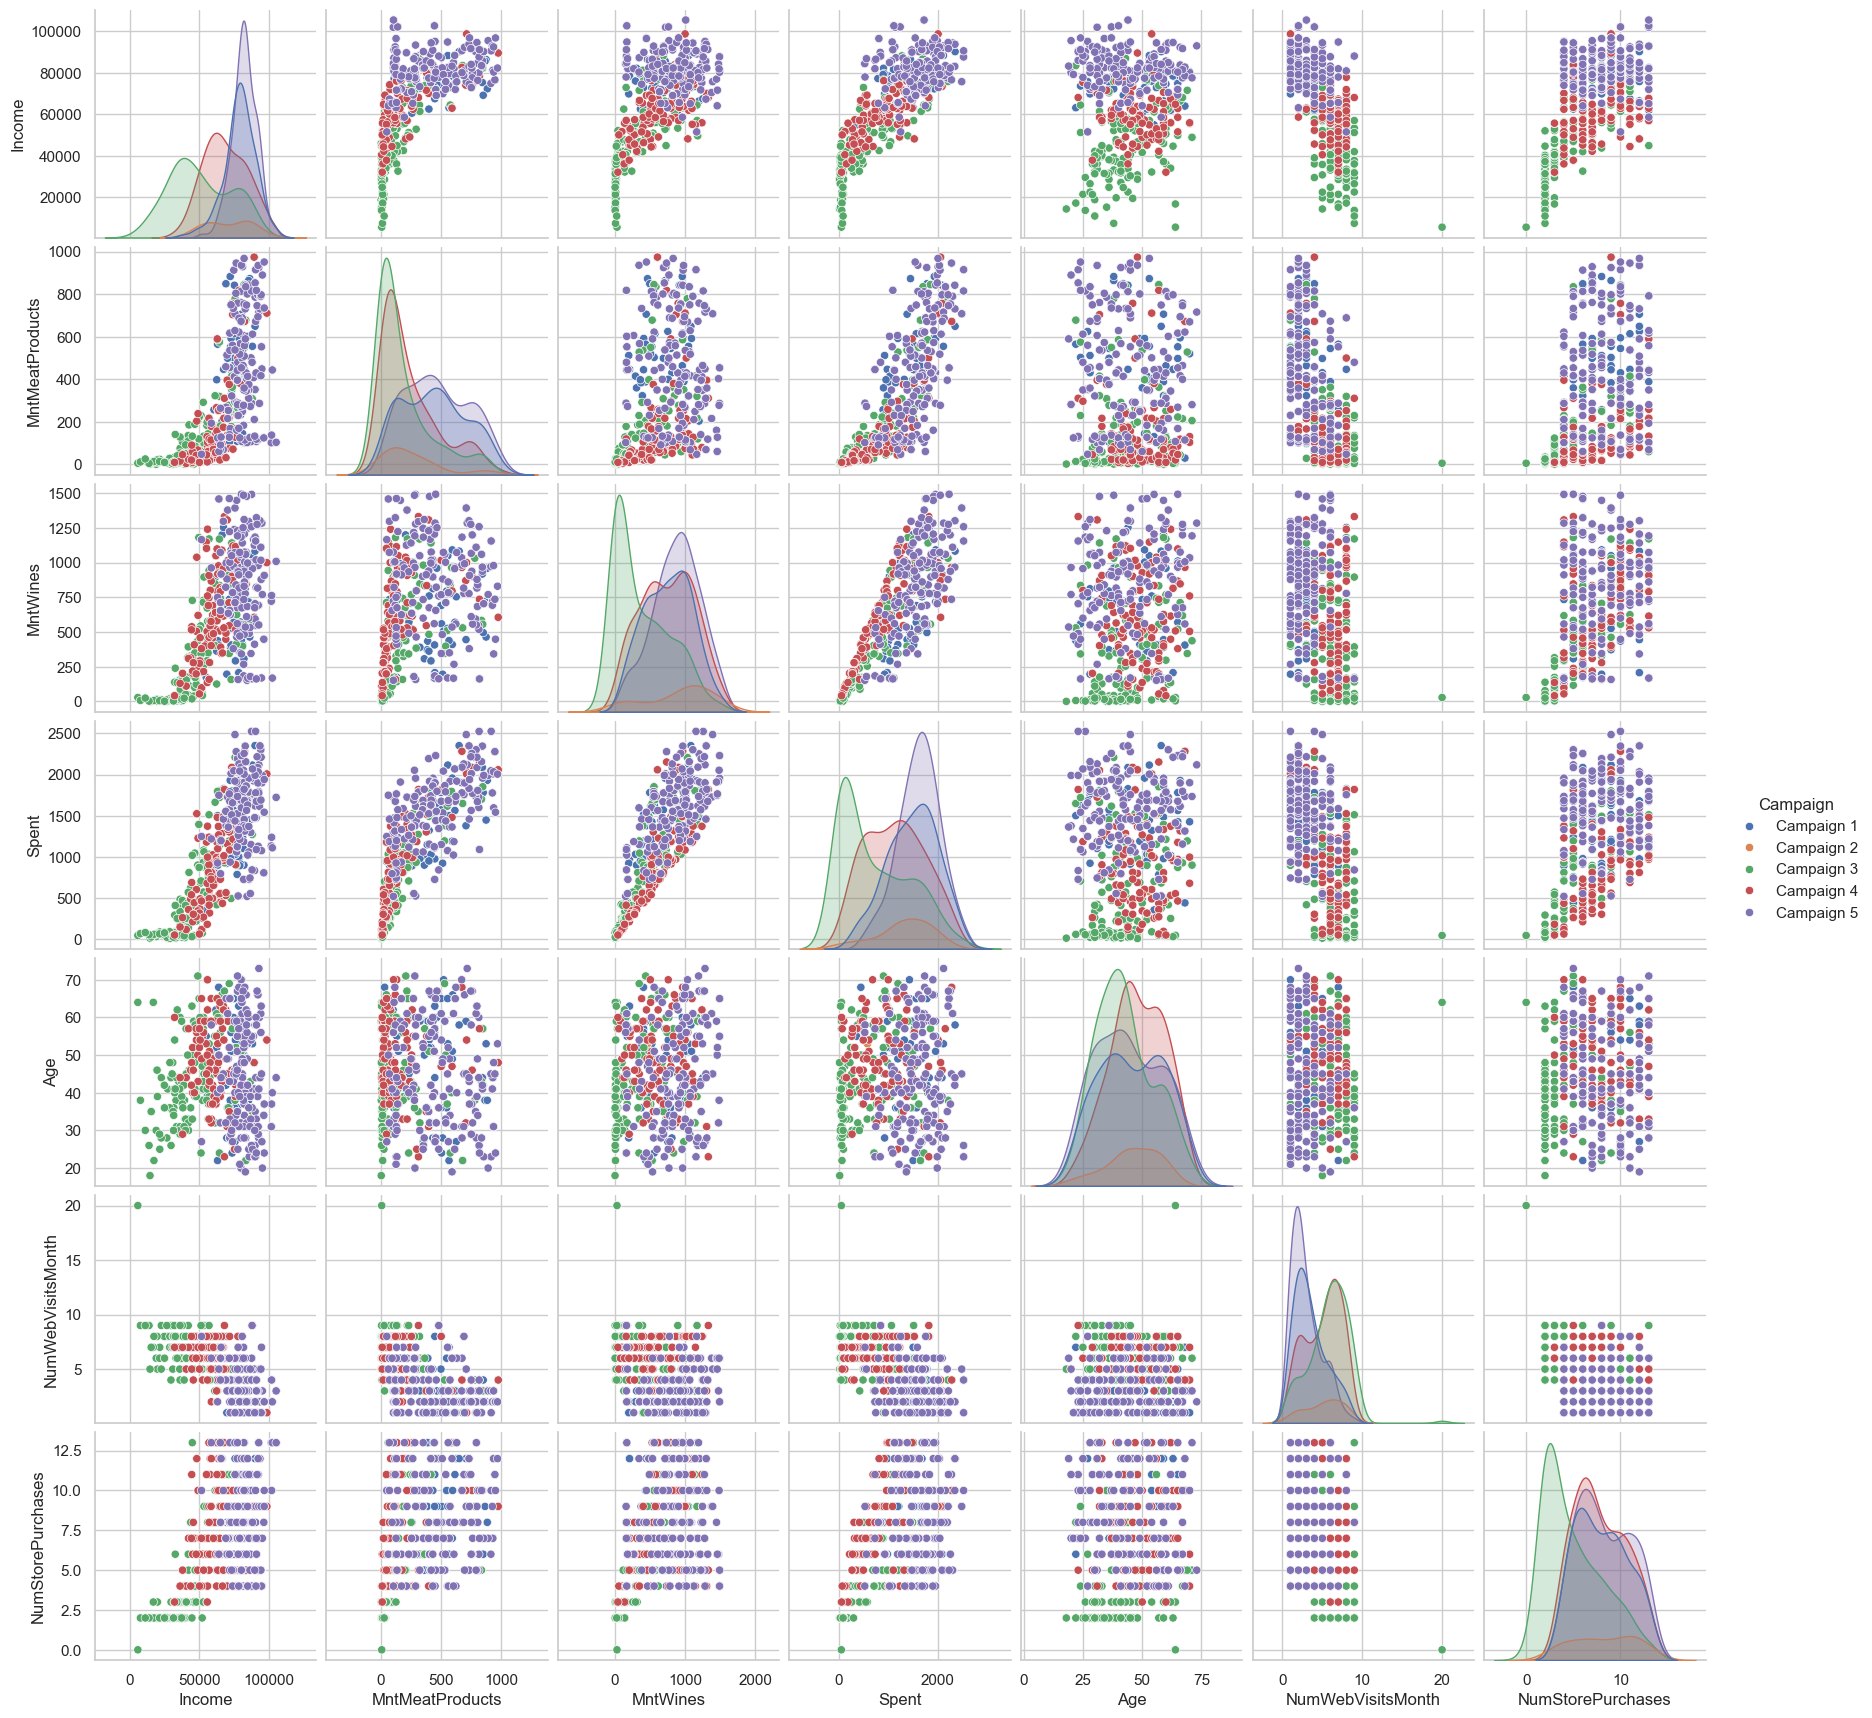

In [29]:
sns.set(style="whitegrid")

cols_to_plot = ["Income", "MntMeatProducts","MntWines", "Spent", "Age","NumWebVisitsMonth","NumStorePurchases" ]

sns.pairplot(
    df_campaign_all,
    vars=cols_to_plot,
    hue="Campaign",
    diag_kind="kde"
)

plt.show()

MANOVA. Multivariated Difference Analysis
- Overall Difference Across all Features
- Each tests whether at least one campaign group differs in the combined set of outcomes.
- Small p-values (< 0.05) mean: some features differ significantly among campaigns.

In [38]:
import pandas as pd

# Combine your campaign groups into one DataFrame
df_campaign_all = pd.concat([
    df_campaign0,
    df_campaign1,
    df_campaign2,
    df_campaign3,
    df_campaign4,
    df_campaign5
], ignore_index=True)

# Ensure Campaign is categorical
df_campaign_all["Campaign"] = df_campaign_all["Campaign"].astype("category")

# print(df_campaign_all["Campaign"].value_counts())

from statsmodels.multivariate.manova import MANOVA

# Select numeric outcome variables
features = ["Income", "Spent", "MntWines", "MntMeatProducts", "Age", "NumWebVisitsMonth", "NumStorePurchases"]

# Build MANOVA formula
formula = " + ".join(features) + " ~ Campaign"

# Run MANOVA
manova = MANOVA.from_formula(formula, data=df_campaign_all)
print(manova.mv_test())


                    Multivariate linear model
                                                                 
-----------------------------------------------------------------
        Intercept        Value  Num DF   Den DF   F Value  Pr > F
-----------------------------------------------------------------
           Wilks' lambda 0.2542 7.0000 2718.0000 1139.2973 0.0000
          Pillai's trace 0.7458 7.0000 2718.0000 1139.2973 0.0000
  Hotelling-Lawley trace 2.9342 7.0000 2718.0000 1139.2973 0.0000
     Roy's greatest root 2.9342 7.0000 2718.0000 1139.2973 0.0000
-----------------------------------------------------------------
                                                                 
-----------------------------------------------------------------
        Campaign        Value   Num DF   Den DF   F Value  Pr > F
-----------------------------------------------------------------
          Wilks' lambda 0.6308 35.0000 11436.0231  37.8180 0.0000
         Pillai's trace 0.3975

One-way ANOVA per Feature
- Which specific feature differ

Turkey HSD
- Which Campaign differ for each

Groups compared: (np.int64(0), np.int64(1))


feature  n_g1  n_g2     mean_g1     mean_g2  diff_g1_minus_g2  \
0           Family_Size   632  1580      1.6013      2.9911           -1.3899   
1              Children   632  1580      0.0000      1.3266           -1.3266   
2     NumDealsPurchases   632  1580      1.1424      2.7975           -1.6551   
3        Spent_Weighted   632  1580   4164.4225   1478.0494         2686.3731   
4                 Spent   632  1580   1104.0649    408.5494          695.5155   
5       MntMeatProducts   632  1580    370.5633     85.6165          284.9468   
6     NumWebVisitsMonth   632  1580      3.4968      6.0513           -2.5544   
7   NumCatalogPurchases   632  1580      4.7674      1.8342            2.9332   
8       MntFishProducts   632  1580     76.5759     22.0778           54.4981   
9                Income   632  1580  65677.3592  46471.3911        19205.9680   
10            MntFruits   632  1580     52.1297     16.0095           36.1203   
11     MntSweetProducts   632  1580     53.1630     16.6000           36.5630   
12             MntWines   632  1580    487.6503    232.3424          255.3079   
13    NumStorePurchases   632  1580      7.2706      5.2209            2.0497   
14         AcceptedCmp5   632  1580      0.2152      0.0158            0.1994   
15         MntGoldProds   632  1580     63.9826     35.9032           28.0794   
16         AcceptedCmp1   632  1580      0.1725      0.0209            0.1516   
17      NumWebPurchases   632  1580      4.4066      3.9608            0.4459   
18         AcceptedCmp4   632  1580      0.1060      0.0614            0.0446   
19         AcceptedCmp2   632  1580      0.0285      0.0076            0.0209   

     t_stat     p_t  equal_var      ci_low     ci_high     df_welch  \
0  -52.6319  0.0000      False     -1.4417     -1.3381  1662.104275   
1  -99.0525  0.0000      False     -1.3529     -1.3003  1579.000000   
2  -25.0145  0.0000      False     -1.7848     -1.5253  1998.184428   
3   25.4431  0.0000      False   2479.1403   2893.6059   857.318158   
4   24.7793  0.0000      False    640.4275    750.6035   888.324686   
5   24.2568  0.0000      False    261.8844    308.0093   724.053671   
6  -22.6927  0.0000      False     -2.7753     -2.3335   938.223592   
7   20.6436  0.0000      False      2.6544      3.2121   892.563223   
8   19.2215  0.0000      False     48.9328     60.0634   815.447006   
9   18.4194  0.0000      False  17159.6506  21252.2854   933.443113   
10  16.9775  0.0000      False     31.9441     40.2964   801.566667   
11  16.7645  0.0000      False     32.2820     40.8440   815.138635   
12  15.5043  0.0000      False    222.9927    287.6231   963.210190   
13  13.5360  0.0000      False      1.7526      2.3468  1089.608795   
14  11.9679  0.0000      False      0.1667      0.2321   677.991398   
15  10.6099  0.0000      False     22.8856     33.2732   937.259476   
16   9.8022  0.0000      False      0.1212      0.1819   704.406660   
17   3.6627  0.0003      False      0.2071      0.6847  1315.588056   
18   3.2657  0.0011      False      0.0178      0.0714   952.413401   
19   2.9952  0.0028      False      0.0072      0.0346   772.197188   

      se_diff  cohens_d  hedges_g    u_stat   p_mwu  p_t_adj_fdr  \
0      0.0264   -2.1273   -2.1266   70680.0  0.0000       0.0000   
1      0.0134   -2.9481   -2.9471       0.0  0.0000       0.0000   
2      0.0662   -0.9331   -0.9328  170494.0  0.0000       0.0000   
3    105.5837    1.4223    1.4218  802732.0  0.0000       0.0000   
4     28.0684    1.3527    1.3522  795411.0  0.0000       0.0000   
5     11.7471    1.5516    1.5510  808047.5  0.0000       0.0000   
6      0.1126   -1.1971   -1.1967  201981.5  0.0000       0.0000   
7      0.1421    1.1234    1.1231  779757.0  0.0000       0.0000   
8      2.8353    1.1137    1.1133  797435.0  0.0000       0.0000   
9   1042.7049    0.9747    0.9743  761879.0  0.0000       0.0000   
10     2.1275    0.9965    0.9962  777174.0  0.0000       0.0000   
11    

### Feature Engineering

## Modelling. Integrated Relationship Analysis

### Clustering. Unsupervised Learning

### Statistical Validation

### Conclusion